![Data Science Lifecycle](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/media/overview/tdsp-lifecycle2.png)

Please note that this is not a linear process. There will be iterations of the whole process but also of parts of the process.

Steps of the data science lifecycle:

1. problem description and objective

2. data acquisition
  * early negotiating data access with stakeholders too reduce risk
  * storing the data securely and according to privacy regulations (GDPR)
  * spend your time wisely. More data samples? More features? Artificially augment data?

3. data exploration using descriptive statistics and visualization

  some options:
  * find out for each feature: data type
  * find out for each feature: numerical, nominal categorical, ordinal categorical
  * heat map to find correlations between features and between features and target variable

4. data preprocessing 
  * dealing with mising data
  * encode categorical features as dummy variables

5. modeling: feature selection

6. modeling: model training
  * algorithm selection
  * hyperparameter tuning

7. modeling: model evaluation
  * choosing evaluation metric
  
8. deployment of the model
  * appify the model
  * continuous monitoring of model performance


# KAGGLE SPECIFIC CODE

In [1]:
########################################## KAGGLE SPECIFIC CODE ####################################################
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

###################################################################################################################

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Let's follow a typical data science workflow #####

# 1. problem description and objective
* problem description: Titanic sank on maiden voyage after colliding with an iceberg, killing 2/3 of the passengers
* objective: predict if a passenger survived or not (binary classification problem)

# 2. data acquisition
* 2a. early negotiating data access with stakeholders too reduce risk
* 2b. storing the data securely and according to privacy regulations (GDPR)
* 2c. spend your time wisely. More data samples? More features? Artificially augment data?


In [2]:
# in this case Kaggle has peformed data acquisition for us
from sklearn.utils import shuffle
df = pd.read_csv("/kaggle/input/titanic/train.csv")  # it has features and labels
kaggle_competition_data = pd.read_csv("/kaggle/input/titanic/test.csv")  # for the Kaggle competition; it has features but has no labels!

# 3. data exploration using descriptive statistics and visualization
Some options:
* 3a. find out for each feature: data type
* 3b. find out for each feature: numerical, nominal categorical, ordinal categorical
* 3c. heat map to find correlations between features and between features and target variable


% of men who survived: 0.18890814558058924

************************* df.head():
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803 

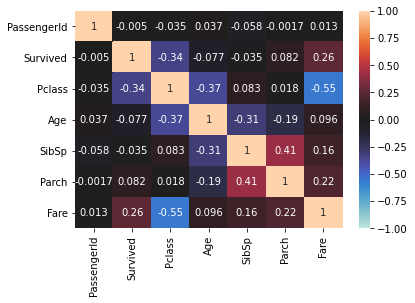

In [3]:
# just a pretty random tryout
men = df.loc[df.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)
print("% of men who survived:", rate_men)

# show some data samples to get a feeling about the data
print('\n************************* df.head():')
print(df.head())
# to note:
# * what is the difference between passenger id and ticket number?

# some descriptive statistics
print('\n************************* df.describe():')
print(df.describe())

# find out the types of the features and find the features that contain missing data (NaN)
print('\n************************* df.info():')
print(df.info())
# to note:
# * feature Cabin has very many missing values
# * feature Age has quite some missing values
# * feature Embarked has missing values
# we also need to investigate the kaggle_competition_data
print('\n************************* kaggle_competition_data.info():')
print(kaggle_competition_data.info())
# to note:
# * feature Fare has missing values

# use google to find information about the feature
# http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf
# (int)(numerical)           PassengerId
# (int)(target variable)     Survived  Survival (0 = No; 1 = Yes)
# (int)(ordinal categorical) Pclass    Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
# (str)(nominal categorical) Name      
# (str)(nominal categorical) Sex       
# (flt)(numerical)           Age       
# (int)(numerical)           SibSp     Number of Siblings/Spouses Aboard
# (int)(numerical)           Parch     Number of Parents/Children Aboard
# (str)(nominal categorical) Ticket    Ticket Number
# (flt)(numerical)           Fare      Passenger Fare (British pound)
# (str)(nominal categorical) Cabin     Cabin (letter of the cabin number indicates the deck)
# (str)(nominal categorical) Embarked  Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

# heatmap: visualization of correlation between features
# heatmap ignores categorical features that are not numbers
import seaborn as sns
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0)

# 4. data preprocessing 
* 4a. dealing with missing data
* 4b. encode categorical features as dummy variables


In [4]:
# below we're going to split df into a training and test set to allow model evaluation. To avoid differences between train 
# and test dataset let's shuffle df so that the split will be random. 
df = shuffle(df)

# it is handy to perform data processing on the complete data set at once, so on df and kaggle_competition_data together
# however df contains labels and kaggle_competition_data does not, so let's split df into features and labels
df_y = df['Survived']
df_X = df.drop('Survived', axis=1)
# to remember what part is df and what part is kaggle_competition_data
df_len = len(df)

# * split the data into trainset (for training), validationset (for hyperparameter turning) and testset (for model evaluation)
# * be very careful that no knowledge of the testset spills into training of the model or hyperparameter tuning
# * note that X, train_X, validation_X and test_X are REFERENCES pointing to the same dataset. So a change to df will be visible
#   in train_data and test_data and vice versa! This is handy, as it allows to perform some actions on the complete data set
#   at once, but also something to continuously be aware of!!
#   Note that sklearn's train_test_split() does NOT have this behavior, so the code below canNOT be replaced with train_test_split()
train_X = df_X[:int(df_len * 0.6)]
validation_X = df_X[int(df_len * 0.6):int(df_len * 0.8)]
test_X = df_X[int(df_len * 0.8):]
train_y = df_y[:int(df_len * 0.6)]
validation_y = df_y[int(df_len * 0.6):int(df_len * 0.8)]
test_y = df_y[int(df_len * 0.8):]
print('length train_X:', len(train_X))
print('length validation_X:', len(validation_X))
print('length test_X:', len(test_X))
print('length test_y:', len(test_y))

# add kaggle_competition_data to df_X
df_X = pd.concat([df_X, kaggle_competition_data], axis=0)

length train_X: 534
length validation_X: 178
length test_X: 179
length test_y: 179


In [5]:
# impute train_data and test_data as random forest alg can't handle missing values
# remember from above, feature Age (numerical), Cabin (categorical) and Embarked (categorical) and Fare (numerical) contain missing values
print('\n************************* df_X.info() before imputation:')
print(df_X.info())
# the fact that there are missing values might in itself be meaningful, so add column to administer where values were missing, 
# so that the model can use this info
df_X[f'Age_wasNan'] = df_X['Age'].isnull()
df_X[f'Fare_wasNan'] = df_X['Fare'].isnull()
# actual imputing
train_X_age_mean = train_X['Age'].mean()  # assumption: missing completely at random (MCAR); imputing with median useful when data is skewed
df_X['Age'].fillna(train_X_age_mean, inplace=True)  # use the mean of train data on validation_data and test_data to avoid leakage!
df_X['Cabin'].fillna('WAS_NAN_CABIN', inplace=True)
df_X['Embarked'].fillna('WAS_NAN_EMBARKED', inplace=True)
train_X_fare_mean = train_X['Fare'].mean()  # ssumption: missing completely at random (MCAR); imputing with median useful when data is skewed
df_X['Fare'].fillna(train_X_fare_mean, inplace=True)  # use the mean of train data on validation_data and test_data to avoid leakage!
print('\n************************* df_X.info() after imputation:')
print(df_X.info())

# hot encode categorical features as random forest cannot handle strings
# * also ordinal categorical features, although of type numerical, need to be one hot encoded as well, 
#   as the distance between the numbers provide wrong information to the training algorithm, affecting the model we train
# * note that get_dummies encodes a missing value into 0,0,0 instead of nan,nan,nan; that's why we perform imputation 
#   *before* one hot encoding
# * don't hot encode the features 'Ticket' and 'Cabin' out of laziness, as we'll drop them later (see below)
categorical_features = ['Pclass', 'Sex', 'Embarked']
df_X = pd.get_dummies(df_X, columns=categorical_features)
print('\n************************* df_X.info() after one hot encoding:')
print(df_X.info())
print('\n************************* train_X.info() after one hot encoding:')
print(train_X.info())
# we see that the changes to df_X are not visible from train_X, so do split again
train_X = df_X[:int(df_len * 0.6)]
validation_X = df_X[int(df_len * 0.6):int(df_len * 0.8)]
test_X = df_X[int(df_len * 0.8):df_len]
kaggle_competition_data = df_X[df_len:]
print('\n************************* train_X.info() after one hot encoding and after resplit:')
print(train_X.info())


************************* df_X.info() before imputation:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 144 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB
None

************************* df_X.info() after imputation:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 144 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------ 

# 5. modeling: feature selection

In [6]:
# Based on the data exploration, let's skip the features 'PassengerId', 'Name', 'Ticket', 'Cabin'
features = train_X.columns
features = [f for f in features if f not in ['PassengerId', 'Name', 'Ticket', 'Cabin']]
train_X = train_X[features]
validation_X = validation_X[features]
test_X = test_X[features]
train_X = train_X[features]
kaggle_competition_X = kaggle_competition_data[features]  # renamed to kaggle_competition_X as we need kaggle_competition_data later

# 6. modeling: model training
* 6a. algorithm selection
* 6b. hyperparameter tuning

In [7]:
# algorithm selection - random forest is flexible, easy to use with great result most of the time
# hyperparameter tuning - for random forest some hyperparameters are n_estimators=100, max_depth=5. A validation data set is used for this.
# Question: why don't we use the test data to perform hyperparameter tuning? Answer: because otherwise the model might become 
# optimized for the test data; this is not good as the model must remain fully independent of the test data to see how well
# the model *generalizes* (== works well on unseen data).
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
for n_estimators in [10, 100, 500]:
    for max_depth in [1, 5, 50]:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=1)
        model.fit(train_X, train_y)
        predictions = model.predict(validation_X)
        print('accuracy_score of prediction on validation data, using n_estimators =', n_estimators, 'and max_depth =', max_depth, ':', accuracy_score(validation_y, predictions))
# using n_estimators = 500 and max_depth = 50 gives highest accuracy on the validation data (several attempts), so we'll use these values
model = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=1)
model.fit(train_X, train_y)

accuracy_score of prediction on validation data, using n_estimators = 10 and max_depth = 1 : 0.7808988764044944
accuracy_score of prediction on validation data, using n_estimators = 10 and max_depth = 5 : 0.8089887640449438
accuracy_score of prediction on validation data, using n_estimators = 10 and max_depth = 50 : 0.7921348314606742
accuracy_score of prediction on validation data, using n_estimators = 100 and max_depth = 1 : 0.7921348314606742
accuracy_score of prediction on validation data, using n_estimators = 100 and max_depth = 5 : 0.8089887640449438
accuracy_score of prediction on validation data, using n_estimators = 100 and max_depth = 50 : 0.8146067415730337
accuracy_score of prediction on validation data, using n_estimators = 500 and max_depth = 1 : 0.7921348314606742
accuracy_score of prediction on validation data, using n_estimators = 500 and max_depth = 5 : 0.8089887640449438
accuracy_score of prediction on validation data, using n_estimators = 500 and max_depth = 50 : 0.

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

# 7. modeling: model evaluation
* 7a. choosing evaluation metric: in this case, Kaggle chooses the evaluation metric "accuracy" for us


In [8]:
# evaluating against the *TRAIN_DATA*
# gives an impression of the BIAS/VARIANCE of the model: to what extent the model is able to fit the train_data
predictions = model.predict(train_X)
print('accuracy_score of prediction on train_data', accuracy_score(train_y, predictions))

# evaluating against the *TEST_DATA*
# shows how well the model GENERALIZES, ability to predict using unseen data
predictions = model.predict(test_X)
print('accuracy_score of prediction on test_data', accuracy_score(test_y, predictions))

accuracy_score of prediction on train_data 0.8576779026217228
accuracy_score of prediction on test_data 0.776536312849162


# 8. deployment of the model
* will be done in a separate hands-on workshop
* very important, but easily forgotten, ALL data transformations that are part of data preparation (e.g. feature normalization,
* imputing, one hot encoding) must be done as well when using the model for predictions, otherwise the predictions will be incorrect.


# 9. Kaggle competition
This step is not part of the data science workflow, but is specific to a Kaggle competition
* 9a. create a submission file. 
* 9b. you upload the submission file to the Kaggle competition using the Kaggle GUI. You'll find the submission file in the right sidebar and then
     under 'data'. After submission, your result will show up in the leader board.

In [9]:
kaggle_competition_predictions = model.predict(kaggle_competition_X)

output = pd.DataFrame({'PassengerId': kaggle_competition_data.PassengerId, 'Survived': kaggle_competition_predictions})  # kaggle_competition_X has no feature PassengerId any more
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# The Kaggle eco-system

Kaggle is owned by Google. Kaggle is so worldwide known, that a good ranking on Kaggle might be as useful as your bachelor degree.
1. Create an account on Kaggle.
2. Search a competition and join.
3. You can start with an empty Jupyter notebook (called a kernel in Kaggle lingo) or start with a copy of somebody else's notebook. With every
   competition there are many, many notebooks from other that you can use for inspiration.
4. With the "Share" button you decide whether others can see your code.
5. You can now add or modify the source code and run the notebook to see the result. Note that "run" does not clear variables from the previous run.
6. Your notebook is a draft and edits are saved automatically (equivalent in git to locally saving your files on your laptop without committing).
7. The notebook runs in the Google cloud and uses fast GPU's (probably faster than your laptop). So it is also a way to get free fast CPU time.
   Also the data files remain in the Google cloud and do not end up on your laptop.
8. If you're happy with your result, you can make a submission, which will show up on the leaderboard. To do this:
  * Save this version of the source code, so that you can look back to it later, by pressing "Save Version" (Save & Run All)
    to commit this version. This version becomes part of you version history (like a git commit). If your notebook as set to
    "public", this committed version will be the version that is visible by others.
  * Click on the number of the version. A new window appears. Click on the ellipsis of the last version, choose "Submit to
    Competition" and submit the output. You'll show up on the leaderboard.
10. Improve your score by improving your code (new iteration). This could be a lead to start: https://www.kaggle.com/eraaz1/a-comprehensive-guide-to-titanic-machine-learning
